## HSPC dataset - $\kappa$-velo 

**In this notebook we will be applying $\kappa$-velo on the HSPC (hematapoietic stem and progenitor cells) dataset. This dataset has been presented for the first time by Yasmin Demerdash on the EHA (European Hematology Association) 2022 Congress. The corresponding paper will be published on Biorxiv at end September (keep an eye out for Bouman and Demerdash et al.).** 

In [1]:
### load libraries

# standard libraries
import numpy as np

# single-cell libraries
import scvelo as scv #used for reading loom file
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing the parameters of the scVelo figures

# dimension reductions
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
from scipy.spatial import cKDTree
import umap #for creating UMAP

# import our own functions
from velocity.processing.filtering import *
from velocity.processing.imputation import *
from velocity.processing.normalisation import *

from velocity.tools.prior import *
from velocity.tools.filtering import *
from velocity.tools.fit import *

from velocity.visualisation.pretty_plotting import *
from velocity.visualisation.vis import *

### Load original dataset
Here, we load the spliced and unspliced matrices from the HSPC dataset using a loom file (`HSPC.loom`). You can download this file and all other needed files from our Github repository (find it under datasets/HSPC). The dataset consists of murine HSPCs. The HSPCs in this dataset were acquired by sorting bone marrow cells using a broad Lin-, c-Kit+ (LK) gating strategy. Additionally, the datasets has been enriched for long-term hematopoietic stem cells (HSCs), which are usually less abundant than other populations.

In [2]:
### load loom file subset
hspc_path = "../datasets/HSPC/HSPC.loom"
adata = ad.read_loom(hspc_path)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In the original processing of the dataset some cells and genes were removed during quality control (for example because they are doublets). Therefore we remove those cells and genes here as well. 

In [3]:
### load cells selected in qc
load_path = "../datasets/HSPC/cells_after_qc.csv"
cell_after_qc = np.loadtxt(load_path, dtype=str)

In [4]:
### change cellnames in loom file to match the cellnames from the original dataset
cellnames = [cellname.replace('possorted_genome_bam_YBF44:','') for cellname in adata.obs_names]
cellnames = [cellname.replace('x','-1-PBS') for cellname in cellnames]
adata.obs_names = cellnames

In [5]:
### remove cells that are filtered out in original pipeline (doublets, etc.)
adata = adata[cell_after_qc,:]

In [6]:
### make names of genes unique
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
### load genes selected in qc
load_path = "../datasets/HSPC/genes_after_qc.csv"
genes_after_qc = np.loadtxt(load_path, dtype=str)

In [8]:
### remove genes that are filtered out in original pipeline 
shared_genes = np.intersect1d(adata.var_names, genes_after_qc)
adata = adata[:,shared_genes]

In this notebook we will define the different populations in the HSPC dataset. To compare these annotations to the original annotations, we will also load the originally assigned cell types into the AnnData object. Additionally, we also load the original UMAP coordinates.

In [9]:
### load original clusters 
load_path = "../datasets/HSPC/original_clusters.csv"
original_clusters = pd.read_csv(load_path, index_col=0)
adata.obs["original_clusters"] = original_clusters

Trying to set attribute `.obs` of view, copying.


In [10]:
### load original colors
original_colors = ['#98df8a', '#d62728', '#aec7e8', '#17becf', '#8c564b', '#b5bd61',
                   '#e377c2', '#279e68', '#ff7f0e', '#aa40fc', '#1f77b4', '#ffbb78']
adata.uns["original_clusters_colors"] = original_colors

In [11]:
### load original UMAP
load_path = "../datasets/HSPC/original_UMAP.csv"
original_umap = np.genfromtxt(load_path, delimiter=',')
adata.obsm["original_umap"] = original_umap

We remove two clusters that have a very low number of cells.

In [12]:
### remove smaller populations
small_populations = ["Eosinophils", "Monocytes"]
adata = adata[[i not in small_populations for i in adata.obs["original_clusters"]],:]

Last, we will add the cell type colors that we found using gene markers in the script `HSPC_marker_genes.ipynb`. You can either run that notebook or download the resulting file `celltypes_colors.csv` from the Github folder datasets/HSPC.

In [13]:
### load cell type colors 
load_path = "../datasets/HSPC/celltypes_colors.csv"
celltypes_colors = pd.read_csv(load_path, header=None).iloc[:,0].values
len(celltypes_colors)

2430

Here we make a copy of the raw loaded AnnData object, because for some of the analyses that we will need a different type of processing. This saves us time repeating all the steps above.

In [14]:
adata_copy = adata.copy()

### Processing
Here, we will process the data according to the $\kappa$-velo workflow. We will select the highly variable genes (HVGs), filter for genes with sufficient unspliced an spliced counts, L1 normalise the data, and last we impute the data. If you are interested in learning more about each individual step we recommend to have a look at Supplementary Note 5 in our manuscript.

In [15]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

In [16]:
### select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=5000, theta=100, layer='spliced')
print("Subsetting to top "+str(len(hvgs))+" highly-variable genes.")
adata = adata[:, hvgs]

Subsetting to top 5000 highly-variable genes.


In [17]:
### get maximum spliced and unspliced counts for each gene
max_unspliced = np.array(np.max(adata.layers["unspliced"], axis=0)).flatten()
max_spliced = np.array(np.max(adata.layers["spliced"], axis=0)).flatten()

In [18]:
minlim = 6

In [19]:
### subset for genes that have high enough U and S counts
us_genes = get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

Subsetting to 531 genes with sufficient S and U counts.


In [20]:
### L1 normalise unspliced and spliced together 
normalise_layers(adata, mode='combined', norm='L1', total_counts=None)

total_counts not given


In [21]:
### imputation
impute_counts(adata, n_neighbours = 30, layer_NN = 'spliced', n_pcs = 15)

In [22]:
adata

AnnData object with n_obs × n_vars = 2430 × 531
    obs: 'original_clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'original_clusters_colors'
    obsm: 'original_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'

### Velocity calculation
To recover the parameters, we will run the function `recover_reaction_rate_pars`. This function takes some time (about 10 minutes) so if you want to save some time you can also just download the recovered parameters from the folder datasets/HSPC in our GitHub page and add them to the AnnData object. After recovering the parameters we run two additional filtering steps. Last, we use the recovered parameters to calculate the velocities.

In [23]:
### recover dynamics for selected genes
#recover_reaction_rate_pars(adata, use_raw=False, n=100, key="fit")

In [24]:
### save recovered parameters
#save_path = "../datasets/HSPC/adata_var_after_recovery.csv"
#adata.var.to_csv(save_path)

In [25]:
### load recovered parameters
load_path = "../datasets/HSPC/adata_var_after_recovery.csv"
adata.var = pd.read_csv(load_path, index_col=0)

In [26]:
### remove likelihood genes
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)
likelihood_genes = likelihood_genes.dropna()
likelihood_genes = likelihood_genes[likelihood_genes >= 0.5]
likelihood_genes = likelihood_genes.index.values
print(str(len(likelihood_genes))+" high-likelihood genes kept")
adata = adata[:, likelihood_genes]

340 high-likelihood genes kept


In [27]:
### set prior state on genes
connections_dict = {'Myel. prog. #3': ['Myel. prog. #2'],
                  'Myel. prog. #2': ['Myel. prog. #1'],
                  'Myel. prog. #1': ['LMPPs #2'],
                  'LMPPs #2': ['LMPPs #1'],
                  'LMPPs #1': ['HSCs #2'],
                  'HSCs #2': ['HSCs #1.'],
                  'Ery. prog. #2': [ 'Ery. prog. #1'],
                    'MK prog.': ['HSCs #2']}

set_prior_state(adata, connections_dict, clusterkey="original_clusters")

In [28]:
### find all genes where prior state matches the recovered state
matching_genes = get_matching_state_genes(adata, total_cells=30, perc_cells=5, perc_match=70)
print(str(len(matching_genes))+" prior state matching genes kept")
adata = adata[:, matching_genes]

138 prior state matching genes kept


In [29]:
### calculate velocity
get_velocity(adata, use_raw=False, key="fit", normalise=None, scale=True)

Trying to set attribute `.layers` of view, copying.


### Plot kinetics slow and fast genes
Here, we will plot the top 20 fast and slow genes found in the HSPC dataset. We use the fitted $\beta$ to determine the speed of the genes. In figure 5D-F from the main paper we show two fast genes (Fcnb and Ermap) and one slow gene (Bptf). We will also plot the expression in a seperate phase portrait for those three genes.

In [30]:
fast_genes = adata.var["fit_beta"].sort_values(ascending=False).index[0:25]
slow_genes = adata.var["fit_beta"].sort_values(ascending=True).index[0:25]

In [31]:
def plot_kinetics(alpha, gamma, spliced, unspliced, Uk, dist=True, weight=1, 
                  k=None, Pi=None, ax=None, c=None,title=None):
    U0, S0 = 0, 0
    Sk = S(alpha, gamma, U0, S0, Uk)
    ax.scatter(spliced, unspliced,c=c, s=5)

    u_range = np.arange(0, Uk + (Uk / 1000), Uk / 1000)
    ax.plot(S(alpha, gamma, U0, S0, u_range), u_range, color="blue")
    
    s_down = S(0, gamma, Uk, Sk, u_range)
    ax.plot(s_down, u_range, color="orange")

    u_steady = np.array([0, u_range[s_down == np.max(s_down)]], dtype=float)
    ax.plot(u_steady / gamma, u_steady, color="grey", alpha=.5)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    ax.set_facecolor('white')
    ax.text(0.05, 0.95, title, style='italic', transform=ax.transAxes, verticalalignment='top', bbox=props)

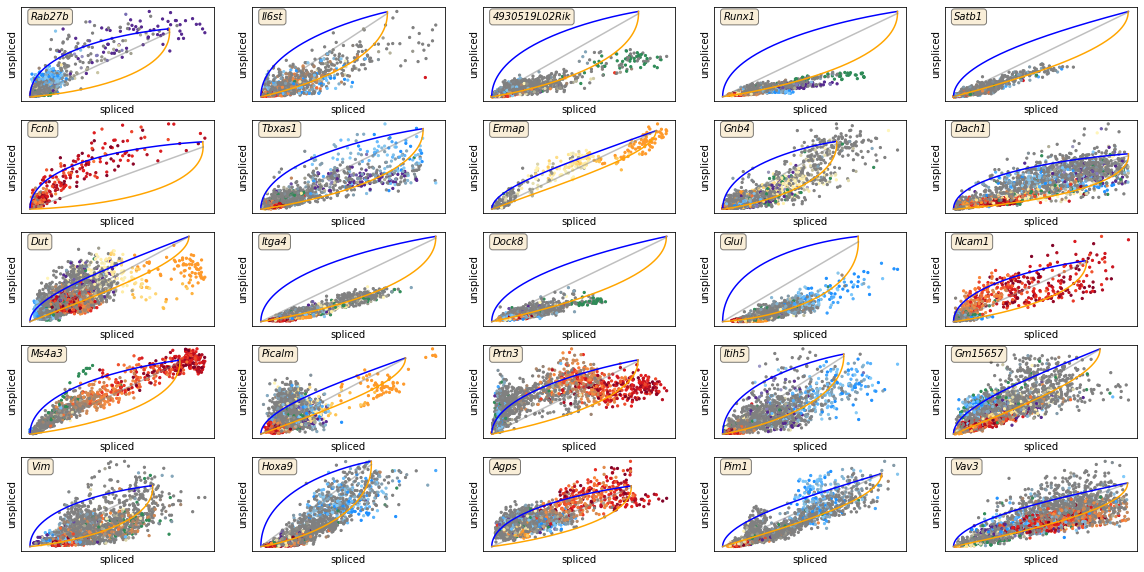

In [32]:
fig, axs = plt.subplots(5, 5, figsize=(20, 10))
axs = axs.ravel()

for i, g in enumerate(fast_genes):
    unspliced, spliced = adata[:, g].layers["Mu"][:, 0], adata[:, g].layers[ "Ms"][:, 0]
    alpha, gamma, beta = adata[:, g].var["fit_alpha"][0], adata[:, g].var["fit_gamma"][0], adata[:, g].var["fit_beta"][0]
    Uk, scaling = adata[:, g].var["fit_U_switch"][0], adata[:, g].var["fit_scaling"][0]
    sub = (unspliced > 0) & (spliced > 0)
    plot_kinetics(alpha / beta, gamma / beta, spliced[sub], unspliced[sub] * scaling, 
                  Uk, dist=True, weight=1, k=None, Pi=None,ax=axs[i], c=celltypes_colors[sub], title=g)

plt.show()

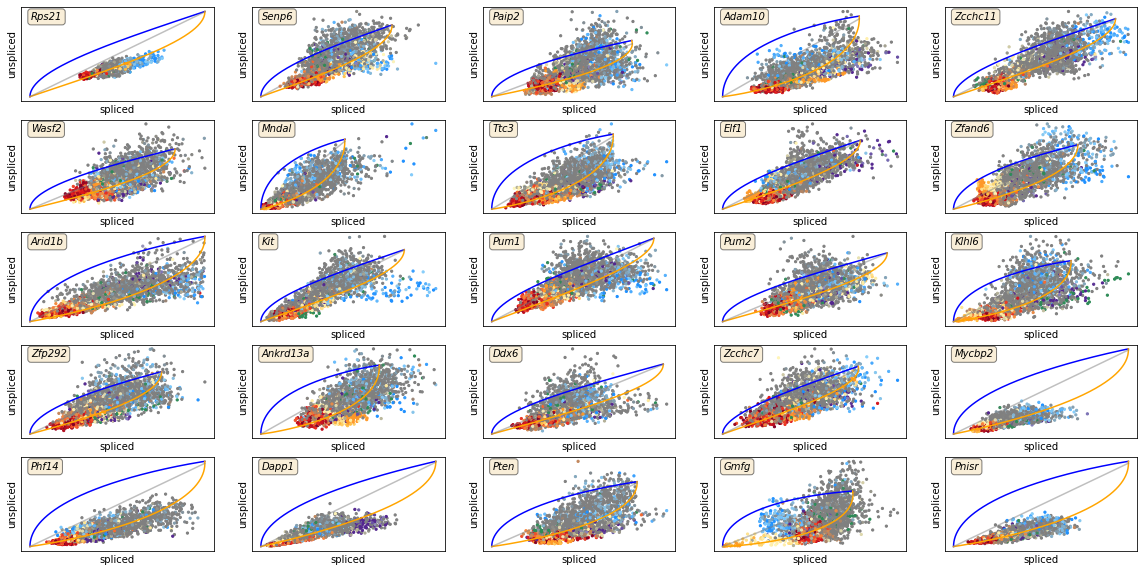

In [33]:
fig, axs = plt.subplots(5, 5, figsize=(20, 10))
axs = axs.ravel()

for i, g in enumerate(slow_genes):
    unspliced, spliced = adata[:, g].layers["Mu"][:, 0], adata[:, g].layers[ "Ms"][:, 0]
    alpha, gamma, beta = adata[:, g].var["fit_alpha"][0], adata[:, g].var["fit_gamma"][0], adata[:, g].var["fit_beta"][0]
    Uk, scaling = adata[:, g].var["fit_U_switch"][0], adata[:, g].var["fit_scaling"][0]
    sub = (unspliced > 0) & (spliced > 0)
    plot_kinetics(alpha / beta, gamma / beta, spliced[sub], unspliced[sub] * scaling, 
                  Uk, dist=True, weight=1, k=None, Pi=None,ax=axs[i], c=celltypes_colors[sub], title=g)

plt.show()

### Visualisation

Last, we want to visualise our calculated velocities. Here we will calculate a new PCA and UMAP embedding for our data and project the velocities onto the embeddings.

**Calculate PCA embedding**

In [34]:
### scale data (imputed spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["Ms"].copy())

In [35]:
### run PCA
np.random.seed(10)
n_pcs = 30
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

**Calculate future states**

In [36]:
### create future states (spliced counts + velocity)
scale = 30
S_fut = adata.layers["Ms"]+(adata.layers["velocity"]*scale)

In [37]:
### scale in the same way as we scaled S
S_fut_scaled = scal.transform(S_fut)

In [38]:
### apply pre-trained PCA transformation on scaled future states
pca_pts_fut = pca.transform(S_fut_scaled)

In [39]:
### get velocity vector in PCA space
pca_v = pca_pts_fut-pca_pts

**Create velocity plots - PCA embedding**

In [40]:
### get lighter colors of each assigned color
light_color = np.array([lighten_color(i, .3) for i in celltypes_colors])

In [41]:
kwargs = {"scale": 1, "angles": "xy", "scale_units": "xy", "edgecolors": "k", "linewidth": 0.5, "headwidth": 5, "headaxislength": 4}

In [42]:
### plot arrows not for all cells (for less crowded)
sub=np.ones(adata.shape[0])  
sub[np.arange(0, adata.shape[0], 3)]=0
sub = sub.astype(bool)

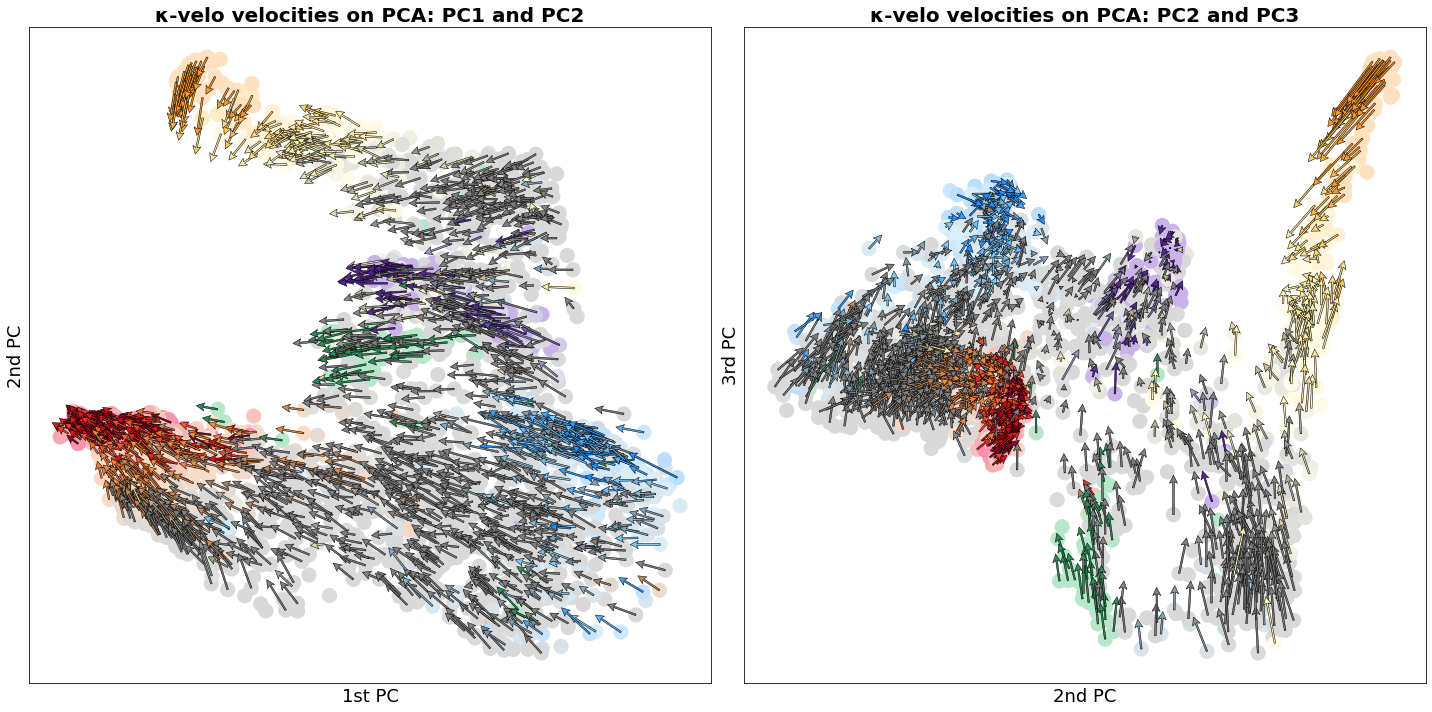

In [43]:
### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# plot points (cells) and arrows (velocities)
axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=light_color, s=200)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=light_color, s=200)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

# axis labels
axs[0].set_xlabel("1st PC", fontsize=18)
axs[0].set_ylabel("2nd PC", fontsize=18)
axs[1].set_xlabel("2nd PC", fontsize=18)
axs[1].set_ylabel("3rd PC", fontsize=18)

# title
axs[0].set_title("κ-velo velocities on PCA: PC1 and PC2", fontsize=20, fontweight="bold")
axs[1].set_title("κ-velo velocities on PCA: PC2 and PC3", fontsize=20, fontweight="bold")

# plot subset of arrows (less crowded plot)
axs[0].quiver(pca_pts[sub,0], pca_pts[sub,1], pca_v[sub,0], pca_v[sub,1], color=celltypes_colors[sub], **kwargs)
axs[1].quiver(pca_pts[sub,1], pca_pts[sub,2], pca_v[sub,1], pca_v[sub,2], color=celltypes_colors[sub], **kwargs)

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_kappa-velo_PCA.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

**Calculate UMAP embedding**
Here, we calculate the UMAP embedding for the HSPC dataset. However, you can also directly load the calculated UMAP coordinates (can also be found on our Github repository under datasets/HSPC).

In [44]:
### calculate UMAP 
#reducer = umap.UMAP(random_state=2, n_neighbors=300, min_dist=1, n_components=2, metric="euclidean")
#UMAP_data = reducer.fit_transform(pca_pts)

In [45]:
### save UMAP coordinates
#save_path = "../datasets/HSPC/UMAP_coordinates_TEST.csv"
#pd.DataFrame(UMAP_data).to_csv(save_path)

In [44]:
### load UMAP coordinates
load_path = "../datasets/HSPC/UMAP_coordinates_TEST.csv"
UMAP_data = np.array(pd.read_csv(load_path, header=0, index_col=0), dtype='float32')

In [45]:
### calculate velocity projections
n_neighbors = 50
UMAP_fut = nystroem_project(UMAP_data, pca_pts, pca_pts_fut, n_neighbors=n_neighbors,force_no_scale=True)
UMAP_v = UMAP_fut-UMAP_data

Projecting velocities using Nyström approach.


**Smoothen velocities**

In [46]:
### get top 30 nearest neighbors
NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]

In [47]:
### calculate smoothed velocities
UMAP_v_mean = np.nanmean(np.array(UMAP_v)[NN], axis=1)

**Create velocity plots - UMAP embedding**

In [48]:
kwargs = {"scale": 1, "angles": "xy", "scale_units": "xy", "edgecolors": "k",
          "linewidth": 0.2,"width": .002,"headwidth": 4,"headaxislength": 4}

In [49]:
light_color = np.array([lighten_color(i, .15) for i in celltypes_colors])

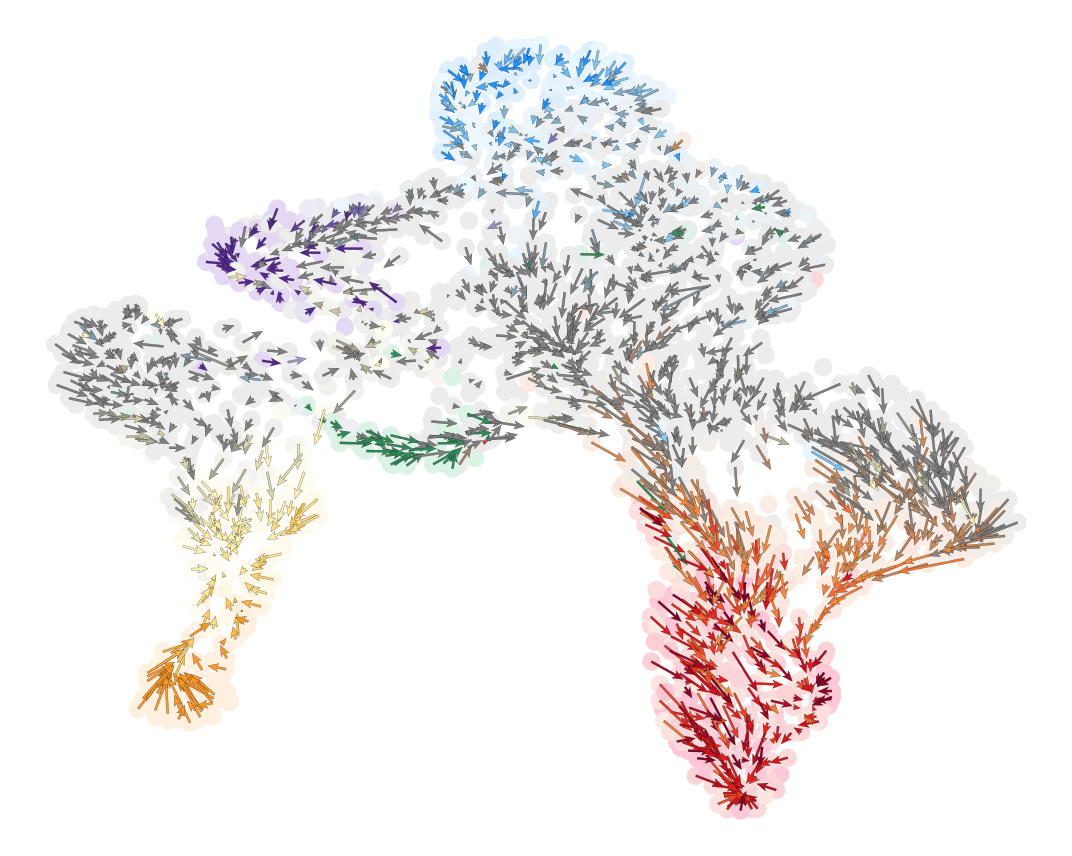

In [50]:
### create UMAP plot of HSPC by kappa-velo
rcParams["axes.spines.left"] = False
rcParams["axes.spines.bottom"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False

fig, ax = plt.subplots(1, 1, figsize=(15, 12), frameon=False)

ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=300)

# make pretty
ax.set_yticks([])
ax.set_xticks([])

# plot arrows 
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], UMAP_v[sub,0], UMAP_v[sub,1], 
              color=celltypes_colors[sub], **kwargs)

plt.tight_layout()
save_path = "../figures/HSPC/HSPC_kappa-velo_UMAP.pdf"
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()

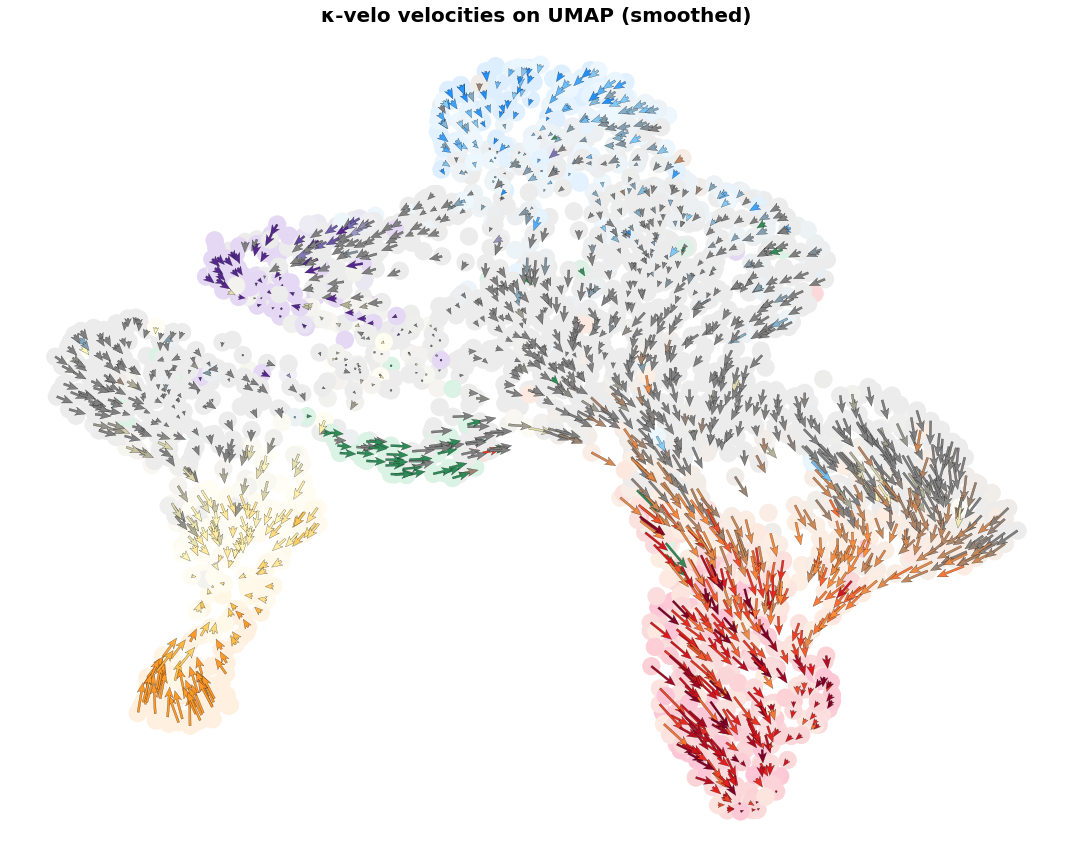

In [51]:
### create UMAP plot of HSPC by kappa-velo (smoothed)
fig, ax = plt.subplots(1, 1, figsize=(15, 12), frameon=False)

ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=300)

# make pretty
ax.set_yticks([])
ax.set_xticks([])

# title
ax.set_title("κ-velo velocities on UMAP (smoothed)", fontsize=20, fontweight="bold")

# plot arrows 
ax.quiver(UMAP_data[sub,0], UMAP_data[sub,1], UMAP_v_mean[sub,0], UMAP_v_mean[sub,1],
          color=celltypes_colors[sub], **kwargs)

plt.tight_layout()
save_path = "../figures/HSPC/HSPC_kappa-velo_UMAP_mean.pdf"
plt.savefig(save_path, dpi=300, transparent=True)
plt.show()

### Run scVelo on HSPC dataset
Now, we will run scVelo's standard pipelineon the HSPC dataset. We will use the same UMAP as we have calculated for $\kappa$-velo for ease of comparison.

In [ ]:
### copy raw dataset for using with scvelo
adata_scvelo = adata_copy.copy()

In [ ]:
### run scVelo pipeline
scv.pp.filter_and_normalize(adata_scvelo, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_scvelo, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata_scvelo, max_iter=100, n_jobs=4)
scv.tl.velocity_graph(adata_scvelo)

In [ ]:
### project on UMAP with scVelo
scv.tl.velocity_graph(adata_scvelo)
adata_scvelo.obsm["X_umap"] = UMAP_data
#scv.pl.velocity_embedding(adata_scvelo, basis='umap', scale=.1)

In [ ]:
light_color = np.array([lighten_color(i, .5) for i in celltypes_colors])

In [ ]:
### create UMAP stream plot of HSPC by scVelo
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), frameon=False)

ax.scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=5)
scv.pl.velocity_embedding_stream(adata_scvelo, basis='umap', ax=ax, show=False, color="white", alpha=0)

# make pretty
ax.set_ylabel("")
ax.set_xlabel("")

# save figure
save_path = "../figures/HSPC/HSPC_scvelo_streamplot.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### Plot UMAP with stemness score
Here, we will analyse the cells in the HSPC dataset for "stemness". In other words, we check each cell for its correspondence with the stem cell identity. We do this using a set of curated genes that was published by Giladi et al. in 2018, specifically for the HSPC compartment (https://doi.org/10.1038/s41556-018-0121-4).

In [52]:
### copy raw dataset for using 
adata_stem = adata_copy.copy()

In [53]:
### add UMAP coordinates
adata_stem.obsm["X_umap"] = UMAP_data

In [54]:
### load libraries
import sklearn as sk
from matplotlib.colors import LinearSegmentedColormap #for own cmap

In [55]:
### process subset
adata_stem.X = adata_stem.layers["spliced"].todense() + adata_stem.layers["unspliced"].todense()
adata_stem.X = sk.preprocessing.normalize(adata_stem.X, norm='l2')
sc.pp.scale(adata_stem)

In [56]:
### load stemness markers
genelist = pd.read_excel("../datasets/HSPC/gene_markers_Giladi_2018.xlsx")
genelist.gene = [str(genename).partition(";")[0] for genename in genelist.gene.values]
stemness_genes = genelist[genelist["gene module"]=="Stem genes"].gene.values

In [57]:
### score for stemness genes
sc.tl.score_genes(adata_stem, stemness_genes, score_name="stemness")

In [58]:
### create own cmap
colors = ["lightgrey", "cornsilk", "orange", "red", "purple", "midnightblue"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

... storing 'original_clusters' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


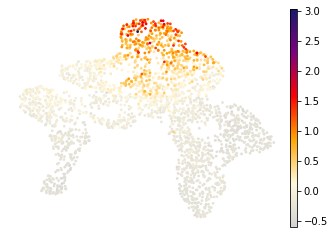

In [59]:
### create figure with stemmness score 
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), frameon=False)

sc.pl.umap(adata_stem, color="stemness", size=30, title="", cmap=custom_cmap, ax=ax, show=False)

# make pretty
ax.set_ylabel("")
ax.set_xlabel("")

# save plot
save_path = "../figures/HSPC/HSPC_stemness_UMAP.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### Plot UMAP and phase portrait selected genes
For Figure 5 in our paper we selected 3 genes to highlight, namely Fcnb, Ermap and Bptf. Here we plot their expression (we take the combination of spliced and unspliced counts).

In [60]:
### select genes
select_genes = ["Fcnb", "Ermap","Pum2"]

In [61]:
### copy raw dataset for using 
adata_exp = adata_copy.copy()

In [62]:
### add UMAP coordinates
adata_exp.obsm["X_umap"] = UMAP_data

In [63]:
### process subset
adata_exp.X = adata_exp.layers["spliced"].todense() + adata_exp.layers["unspliced"].todense()
adata_exp.X = sk.preprocessing.normalize(adata_exp.X, norm='l2')

In [64]:
### create own cmap
colors = ["lightgrey", "cornsilk", "orange", "red", "purple", "midnightblue"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

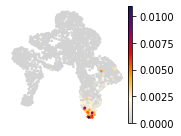

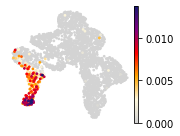

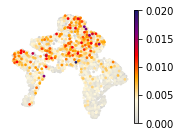

In [78]:
### plot UMAP with expression for each selected genes
for gene in select_genes:
    fig, ax = plt.subplots(1, 1, figsize=(2.6, 2), frameon=False)
    sc.pl.umap(adata_exp, color=gene, size=30, title="", cmap=custom_cmap, ax=ax, show=False, vmax=max(adata_exp[:,gene].X)*0.8)
    
    # make pretty
    ax.axis('off')
    
    # save plot
    save_path = "../figures/HSPC/HSPC_expression_UMAP_"+gene+".pdf"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, transparent=True)
    
    plt.show()

In [66]:
def plot_kinetics(alpha, gamma, spliced, unspliced, Uk, dist=True, weight=1, 
                  k=None, Pi=None, ax=None, c=None,title=None):
    U0, S0 = 0, 0
    Sk = S(alpha, gamma, U0, S0, Uk)
    ax.scatter(spliced, unspliced,c=c, s=15)

    u_range = np.arange(0, Uk + (Uk / 1000), Uk / 1000)
    ax.plot(S(alpha, gamma, U0, S0, u_range), u_range, color="blue")
    
    s_down = S(0, gamma, Uk, Sk, u_range)
    ax.plot(s_down, u_range, color="orange")

    u_steady = np.array([0, u_range[s_down == np.max(s_down)]], dtype=float)
    ax.plot(u_steady / gamma, u_steady, color="grey", alpha=.5)

    ax.axis('off')
    ax.set_facecolor('white')

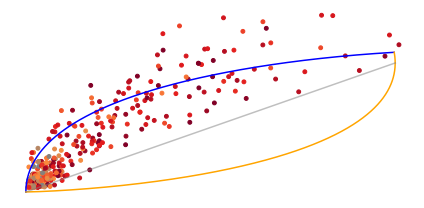

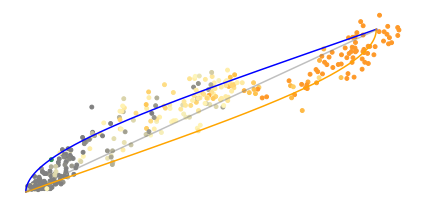

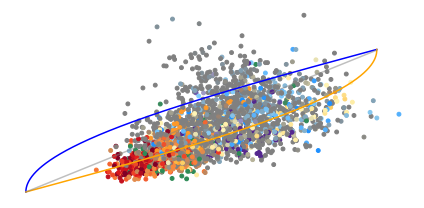

In [67]:
for i, g in enumerate(select_genes):
    fig, axs = plt.subplots(1, 1, figsize=(6, 3))
    unspliced, spliced = adata[:, g].layers["Mu"][:, 0], adata[:, g].layers[ "Ms"][:, 0]
    alpha, gamma, beta = adata[:, g].var["fit_alpha"][0], adata[:, g].var["fit_gamma"][0], adata[:, g].var["fit_beta"][0]
    Uk, scaling = adata[:, g].var["fit_U_switch"][0], adata[:, g].var["fit_scaling"][0]
    sub = (unspliced > 0) & (spliced > 0)
    plot_kinetics(alpha / beta, gamma / beta, spliced[sub], unspliced[sub] * scaling, 
                  Uk, dist=True, weight=1, k=None, Pi=None,ax=axs, c=celltypes_colors[sub], title=g)
    
    # save figure
    save_path = "../figures/HSPC/phase_portrait_"+g+".png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, transparent=True)
    
    plt.show()

### Compare cell type assignments
In script `HSPC_marker_genes.csv` we use marker genes to find some of the main cell types in our dataset. To check whether our assignments match the assignments in the original paper we create two UMAPs with both clusterings side by side.

In [68]:
adata.obs["original_clusters"] = adata.obs["original_clusters"].astype('category')

In [69]:
color_dict = dict(zip(adata.obs["original_clusters"].cat.categories, adata.uns["original_clusters_colors"]))
original_colors=adata.obs["original_clusters"].map(color_dict)

In [70]:
### add UMAP coordinates
adata.obsm["X_umap"] = UMAP_data

In [71]:
from matplotlib.lines import Line2D

In [72]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Eo/basinophil prog.', markerfacecolor='seagreen', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Erythroid prog.', markerfacecolor='gold', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='HSCs', markerfacecolor='dodgerblue', markersize=10), 
                   Line2D([0], [0], marker='o', color='w', label='Megakaryocyte prog.', markerfacecolor='#54278f', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Myeloid prog.', markerfacecolor='#e31a1c', markersize=10),]

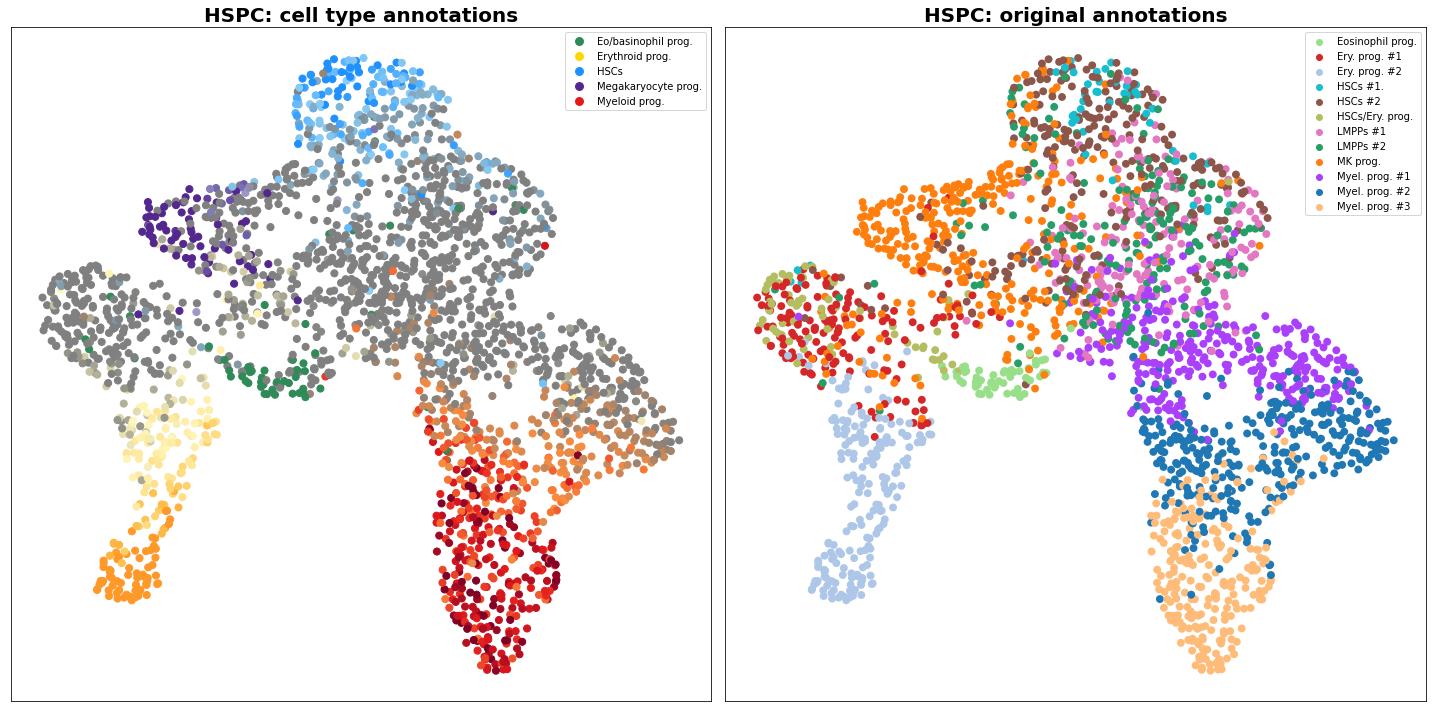

In [73]:
### create UMAP with cell types 
rcParams["axes.spines.left"] = True
rcParams["axes.spines.bottom"] = True
rcParams["axes.spines.right"] = True
rcParams["axes.spines.top"] = True

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# plot points (cells) and arrows (velocities)
axs[0].scatter(UMAP_data[:,0], UMAP_data[:,1], color=celltypes_colors, s=50)
sc.pl.umap(adata_stem, color="original_clusters", size=250, title="", 
           ax=axs[1], show=False)

# axis labels
axs[0].set_xlabel("", fontsize=18)
axs[0].set_ylabel("", fontsize=18)
axs[1].set_xlabel("", fontsize=18)
axs[1].set_ylabel("", fontsize=18)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

axs[0].legend(handles=legend_elements, loc='upper right')
axs[1].legend(loc='upper right')

# title
axs[0].set_title("HSPC: cell type annotations", fontsize=20, fontweight="bold")
axs[1].set_title("HSPC: original annotations", fontsize=20, fontweight="bold")

# save plot
plt.tight_layout()
save_path = "../figures/HSPC/HSPC_original_vs_our_annotion.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()